In [13]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
DATA_DIR = "data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2

WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [2]:
def load_selected_csvs(base_dir):
    dfs = []

    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(
                    os.path.basename(csv_path)
                )[0]
                dfs.append(df)

    print(
        f"Loaded {len(dfs)} recordings | "
        f"Activities={SELECTED_ACTIVITIES} | "
        f"Positions={SELECTED_POSITIONS}"
    )
    return dfs

In [3]:
def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

In [4]:
def extract_features(window, cols):
    feats = []

    for c in cols:
        x = window[c].values

        # Time-domain features
        feats.extend([
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x ** 2)),
            np.sum(np.abs(x)) / len(x)
        ])

        # Frequency-domain features
        fft_vals = np.fft.rfft(x)
        fft_mag = np.abs(fft_vals) / len(fft_vals)

        feats.extend([
            np.mean(fft_mag),
            np.std(fft_mag),
            np.max(fft_mag),
            np.sum(fft_mag)
        ])

    return feats

def build_dataset(dfs, feature_cols):
    X, y, groups, positions = [], [], [], []

    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            X.append(extract_features(w, feature_cols))
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
            positions.append(w["phone_position"].iloc[0])

    return (
        np.array(X),
        np.array(y),
        np.array(groups),
        np.array(positions)
    )

In [11]:
def evaluate_knn(X, y, groups, title):
    outer_cv = GroupKFold(n_splits=5)

    y_true_all, y_pred_all = [], []

    param_grid = {
        "knn__n_neighbors": list(range(3, 16, 2)),
        "knn__weights": ["uniform", "distance"],
        "knn__metric": ["euclidean", "manhattan", "cosine"]
    }

    for fold, (train_idx, test_idx) in enumerate(
        outer_cv.split(X, y, groups), 1
    ):
        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier())
        ])

        inner_cv = GroupKFold(n_splits=4)

        grid = GridSearchCV(
            pipeline,
            param_grid,
            cv=inner_cv,
            scoring="f1_macro",
            n_jobs=-1
        )

        grid.fit(
            X[train_idx],
            y[train_idx],
            groups=groups[train_idx]
        )

        print(f"\nFold {fold} best params:", grid.best_params_)

        best_model = grid.best_estimator_
        preds = best_model.predict(X[test_idx])

        y_true_all.extend(y[test_idx])
        y_pred_all.extend(preds)

    print(f"\n=== {title} ===")
    print(classification_report(y_true_all, y_pred_all, digits=4))

    cm = confusion_matrix(
        y_true_all,
        y_pred_all,
        labels=SELECTED_ACTIVITIES
    )

    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=SELECTED_ACTIVITIES,
        yticklabels=SELECTED_ACTIVITIES,
        cmap="Blues"
    )
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_true_all, y_pred_all, average="macro"),
        "recall": recall_score(y_true_all, y_pred_all, average="macro"),
        "f1": f1_score(y_true_all, y_pred_all, average="macro")
    }

Loaded 100 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand', 'nondom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.95776101 0.95755158 0.95581837 0.9558156  0.95334791 0.95286082
 0.9523544  0.95259986 0.9496595  0.95015564 0.94768665 0.94842427
 0.94514334 0.94588959        nan 0.95553417        nan 0.95230485
        nan 0.9502843         nan 0.95048039        nan 0.94701606
        nan 0.94620469        nan 0.94531951 0.95841968 0.95844036
 0.95785334 0.95935759 0.95629156 0.95780443 0.95425502 0.95727647
 0.95221862 0.95501701 0.95171472 0.95351385 0.94689455 0.95070897]
  warnings.warn(



Fold 1 best params: {'knn__metric': 'cosine', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.94342547 0.94308273 0.94357145 0.94317287 0.93951231 0.93885103
 0.938787   0.93929964 0.93750603 0.93728574 0.93481719 0.93557035
 0.93286094 0.93432592        nan 0.94053729        nan 0.93735228
        nan 0.9359378         nan 0.93471023        nan 0.9337054
        nan 0.93370584        nan 0.93271316 0.94772064 0.94798484
 0.9456562  0.94643689 0.94113835 0.94292521 0.9390838  0.94212474
 0.93727643 0.93906113 0.93473977 0.93651124 0.931102   0.93597684]
  warnings.warn(



Fold 2 best params: {'knn__metric': 'cosine', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.95082415 0.95083724 0.9456518  0.94568225 0.94249216 0.94273824
 0.94044228 0.9407042  0.93944121 0.93971062 0.93720814 0.93747755
 0.93418577 0.93573195        nan 0.95440367        nan 0.95167712
        nan 0.94774922        nan 0.94345059        nan 0.94073621
        nan 0.93922749        nan 0.93695722 0.95080122 0.95084234
 0.94908995 0.94983027 0.94458071 0.94634174 0.94153251 0.94462516
 0.94094887 0.94453233 0.93894531 0.94276028 0.93584513 0.94124538]
  warnings.warn(



Fold 3 best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.94639589 0.94543307 0.94457037 0.94386752 0.9401193  0.94012083
 0.93813789 0.93867165 0.93596927 0.93698862 0.93514516 0.93564472
 0.93294444 0.93490627        nan 0.94691868        nan 0.94570257
        nan 0.94299411        nan 0.94103484        nan 0.93931901
        nan 0.93757159        nan 0.93633014 0.94684159 0.94638657
 0.9431379  0.94414829 0.94108596 0.94235589 0.94257774 0.94410223
 0.94006068 0.94081462 0.93756661 0.93930924 0.93504745 0.93853382]
  warnings.warn(



Fold 4 best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.95527101 0.95531694 0.95205963 0.95207265 0.94853789 0.94955663
 0.94373466 0.94526049 0.94176899 0.94402743 0.93820766 0.94073302
 0.93641893 0.9377001         nan 0.95204087        nan 0.94731923
        nan 0.94727752        nan 0.94601576        nan 0.94248757
        nan 0.93946737        nan 0.93596537 0.95318388 0.95448342
 0.95122541 0.95301942 0.94968221 0.95150173 0.94872882 0.95024335
 0.94516473 0.94724496 0.94206169 0.94592071 0.9392994  0.94389548]
  warnings.warn(



Fold 5 best params: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}

=== KNN Raw Device Frame ===
              precision    recall  f1-score   support

         run     0.9903    0.9832    0.9868      1250
         sit     0.9703    0.9928    0.9814      1250
      stairs     0.9541    0.9129    0.9331      1275
        walk     0.9175    0.9432    0.9302      1250

    accuracy                         0.9578      5025
   macro avg     0.9581    0.9580    0.9579      5025
weighted avg     0.9580    0.9578    0.9577      5025



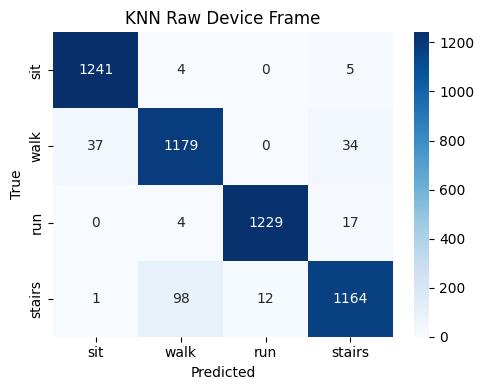

C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.89369788 0.89410218 0.89443736 0.8963244  0.88785037 0.88934243
 0.88491271 0.88743443 0.88407685 0.8863876  0.87799859 0.88009819
 0.87371009 0.87760711        nan 0.90473485        nan 0.90564418
        nan 0.90589673        nan 0.90423161        nan 0.90203953
        nan 0.90124179        nan 0.89588269 0.8697001  0.8736097
 0.86230542 0.86742045 0.85721518 0.86577677 0.85360573 0.86282723
 0.84782767 0.85923811 0.84180813 0.85408136 0.83304001 0.84805516]
  warnings.warn(



Fold 1 best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.88223363 0.88410104 0.8861664  0.88572425 0.88136448 0.88304276
 0.88283401 0.88513544 0.88237397 0.88419185 0.88172321 0.88149046
 0.87703722 0.87853014        nan 0.89668806        nan 0.89703475
        nan 0.89574825        nan 0.89120103        nan 0.89052752
        nan 0.88838759        nan 0.88798861 0.86445857 0.86564777
 0.85855607 0.8600819  0.85386126 0.85787311 0.84584352 0.85104196
 0.84159968 0.8458355  0.83675951 0.84441256 0.8311456  0.8406104 ]
  warnings.warn(



Fold 2 best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.88251054 0.88427004 0.87892394 0.87952002 0.87410646 0.87694681
 0.8724322  0.87396628 0.87181407 0.87381551 0.86680163 0.86986963
 0.85912363 0.86420781        nan 0.89572669        nan 0.89799003
        nan 0.8954354         nan 0.89515774        nan 0.88741446
        nan 0.88493308        nan 0.88236504 0.85022795 0.85333498
 0.84319842 0.84771915 0.83638593 0.84159215 0.8260122  0.83417599
 0.82291869 0.83086488 0.81671714 0.82773414 0.81079075 0.82320575]
  warnings.warn(



Fold 3 best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.86871507 0.87045996 0.86947986 0.86965671 0.86196272 0.86338633
 0.85729632 0.85797803 0.85459082 0.85589783 0.84818077 0.84810962
 0.84455868 0.84634486        nan 0.87579627        nan 0.87910182
        nan 0.87301259        nan 0.87338414        nan 0.86671195
        nan 0.86695501        nan 0.86214584 0.85058407 0.85220486
 0.84336404 0.84742335 0.83867507 0.8428268  0.83161016 0.83669365
 0.83066941 0.83642047 0.82652835 0.83286207 0.81987372 0.8300111 ]
  warnings.warn(



Fold 4 best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}


C:\Users\wenzh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.87732236 0.88201522 0.88116943 0.88408808 0.88117064 0.88279614
 0.8788691  0.88003583 0.881312   0.88267396 0.87722491 0.87966853
 0.87249606 0.87569041        nan 0.89776613        nan 0.89709467
        nan 0.89302427        nan 0.89577844        nan 0.89048477
        nan 0.88878626        nan 0.88673691 0.85876968 0.8602172
 0.85420348 0.85876897 0.85141555 0.85662519 0.84486388 0.85042016
 0.84287472 0.84689419 0.83623476 0.84595417 0.82928143 0.84292496]
  warnings.warn(



Fold 5 best params: {'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'distance'}

=== KNN Global Frame (GFT) ===
              precision    recall  f1-score   support

         run     0.9530    0.9736    0.9632      1250
         sit     0.9571    0.9816    0.9692      1250
      stairs     0.9039    0.7671    0.8299      1275
        walk     0.8107    0.8976    0.8519      1250

    accuracy                         0.9043      5025
   macro avg     0.9062    0.9050    0.9035      5025
weighted avg     0.9062    0.9043    0.9032      5025



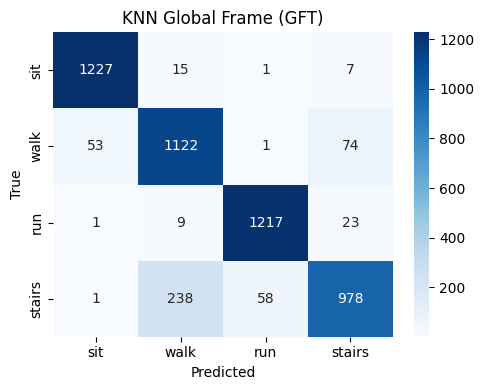


========== SUMMARY ==========
Raw Device Frame: {'precision': 0.958056938878919, 'recall': 0.9580352941176471, 'f1': 0.9578528836619231}
Global Frame (GFT): {'precision': 0.9061721261815382, 'recall': 0.9049647058823529, 'f1': 0.9035491189262508}


In [12]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    X_raw, y_raw, g_raw, _ = build_dataset(recordings, RAW_FEATURES)
    raw_metrics = evaluate_knn(
        X_raw, y_raw, g_raw,
        "KNN Raw Device Frame"
    )

    X_gft, y_gft, g_gft, _ = build_dataset(recordings, GFT_FEATURES)
    gft_metrics = evaluate_knn(
        X_gft, y_gft, g_gft,
        "KNN Global Frame (GFT)"
    )

    print("\n========== SUMMARY ==========")
    print("Raw Device Frame:", raw_metrics)
    print("Global Frame (GFT):", gft_metrics)